In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint

In [128]:
df= pd.read_csv("../MLG_customer_segmentation/data/Lung_cancer_dataset.csv")
print(df.shape)
df.head()

(5000, 18)


,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES


In [3]:
df.describe()

,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE
count,5000.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,57.222800,0.501200,0.666400,0.6012,0.539800,0.516000,0.439200,55.032043,0.394800,0.80040,0.354200,0.698200,94.991029,0.600600,0.301800,0.204000,0.209600
std,15.799224,0.500049,0.471546,0.4897,0.498463,0.499794,0.496339,7.913083,0.488857,0.39974,0.478318,0.459085,1.481048,0.489824,0.459085,0.403009,0.407064
min,30.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,23.258308,0.000000,0.00000,0.000000,0.000000,89.923133,0.000000,0.000000,0.000000,0.000000
25%,44.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,49.440685,0.000000,1.00000,0.000000,0.000000,93.973176,0.000000,0.000000,0.000000,0.000000
50%,57.000000,1.000000,1.000000,1.0000,1.000000,1.000000,0.000000,55.050421,0.000000,1.00000,0.000000,1.000000,94.974073,1.000000,0.000000,0.000000,0.000000
75%,71.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,60.323320,1.000000,1.00000,1.000000,1.000000,95.989272,1.000000,1.000000,0.000000,0.000000
max,84.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,83.046971,1.000000,1.00000,1.000000,1.000000,99.795786,1.000000,1.000000,1.000000,1.000000


In [41]:
df.isnull().any()

AGE                       False
GENDER                    False
SMOKING                   False
FINGER_DISCOLORATION      False
MENTAL_STRESS             False
EXPOSURE_TO_POLLUTION     False
LONG_TERM_ILLNESS         False
ENERGY_LEVEL              False
IMMUNE_WEAKNESS           False
BREATHING_ISSUE           False
ALCOHOL_CONSUMPTION       False
THROAT_DISCOMFORT         False
OXYGEN_SATURATION         False
CHEST_TIGHTNESS           False
FAMILY_HISTORY            False
SMOKING_FAMILY_HISTORY    False
STRESS_IMMUNE             False
PULMONARY_DISEASE         False
dtype: bool

checked for low occurence categories but most features are binary, so no need to group low occurence categories

### Train test split

In [3]:
features= df.drop('PULMONARY_DISEASE', axis="columns")
target=df["PULMONARY_DISEASE"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=False)
X_train.shape, X_test.shape

((3500, 17), (1500, 17))

### Separate categorical and numeric variables

In [4]:
numeric= ["AGE", "ENERGY_LEVEL", "OXYGEN_SATURATION"]
cat= ["GENDER", "SMOKING", "FINGER_DISCOLORATION", "MENTAL_STRESS", "EXPOSURE_TO_POLLUTION", "LONG_TERM_ILLNESS",
     "IMMUNE_WEAKNESS", "BREATHING_ISSUE", "ALCOHOL_CONSUMPTION", "THROAT_DISCOMFORT", "CHEST_TIGHTNESS",
     "FAMILY_HISTORY", "SMOKING_FAMILY_HISTORY", "STRESS_IMMUNE"]

features_num= X_train.drop(columns= cat).columns.tolist()
features_cat= X_train.drop(columns= numeric).columns.tolist()
df_num= df.drop(columns= cat)
df_cat= df.drop(columns= numeric)

features_num, features_cat

(['AGE', 'ENERGY_LEVEL', 'OXYGEN_SATURATION'],
 ['GENDER',
  'SMOKING',
  'FINGER_DISCOLORATION',
  'MENTAL_STRESS',
  'EXPOSURE_TO_POLLUTION',
  'LONG_TERM_ILLNESS',
  'IMMUNE_WEAKNESS',
  'BREATHING_ISSUE',
  'ALCOHOL_CONSUMPTION',
  'THROAT_DISCOMFORT',
  'CHEST_TIGHTNESS',
  'FAMILY_HISTORY',
  'SMOKING_FAMILY_HISTORY',
  'STRESS_IMMUNE'])

In [129]:
def plot_count_facets(df, grouping_column):
    """
    Groups a DataFrame by a specified column and plots count plots of each binary feature
    in a facet grid.

    Args:
        df (pd.DataFrame): The DataFrame to process.
        grouping_column (str): The column to group by.
    """

    # Get the list of binary columns (excluding the grouping column)
    binary_columns = [col for col in df.columns if col != grouping_column and df[col].nunique() == 2]

    # Melt the DataFrame to long format, suitable for seaborn's facet grid
    melted_df = pd.melt(df, id_vars=grouping_column, value_vars=binary_columns,
                        var_name='feature', value_name='value')

    # Create the facet grid
    g = sns.FacetGrid(melted_df, col='feature', col_wrap=3, sharey=False)  # Adjust col_wrap as needed

    # Use countplot with correct column mapping
    g.map_dataframe(sns.countplot, x="value", hue=grouping_column, palette="Dark2",
                   alpha=0.8)

    # Adjust layout and show the plot
    g.fig.tight_layout()
    plt.legend()
    plt.show()

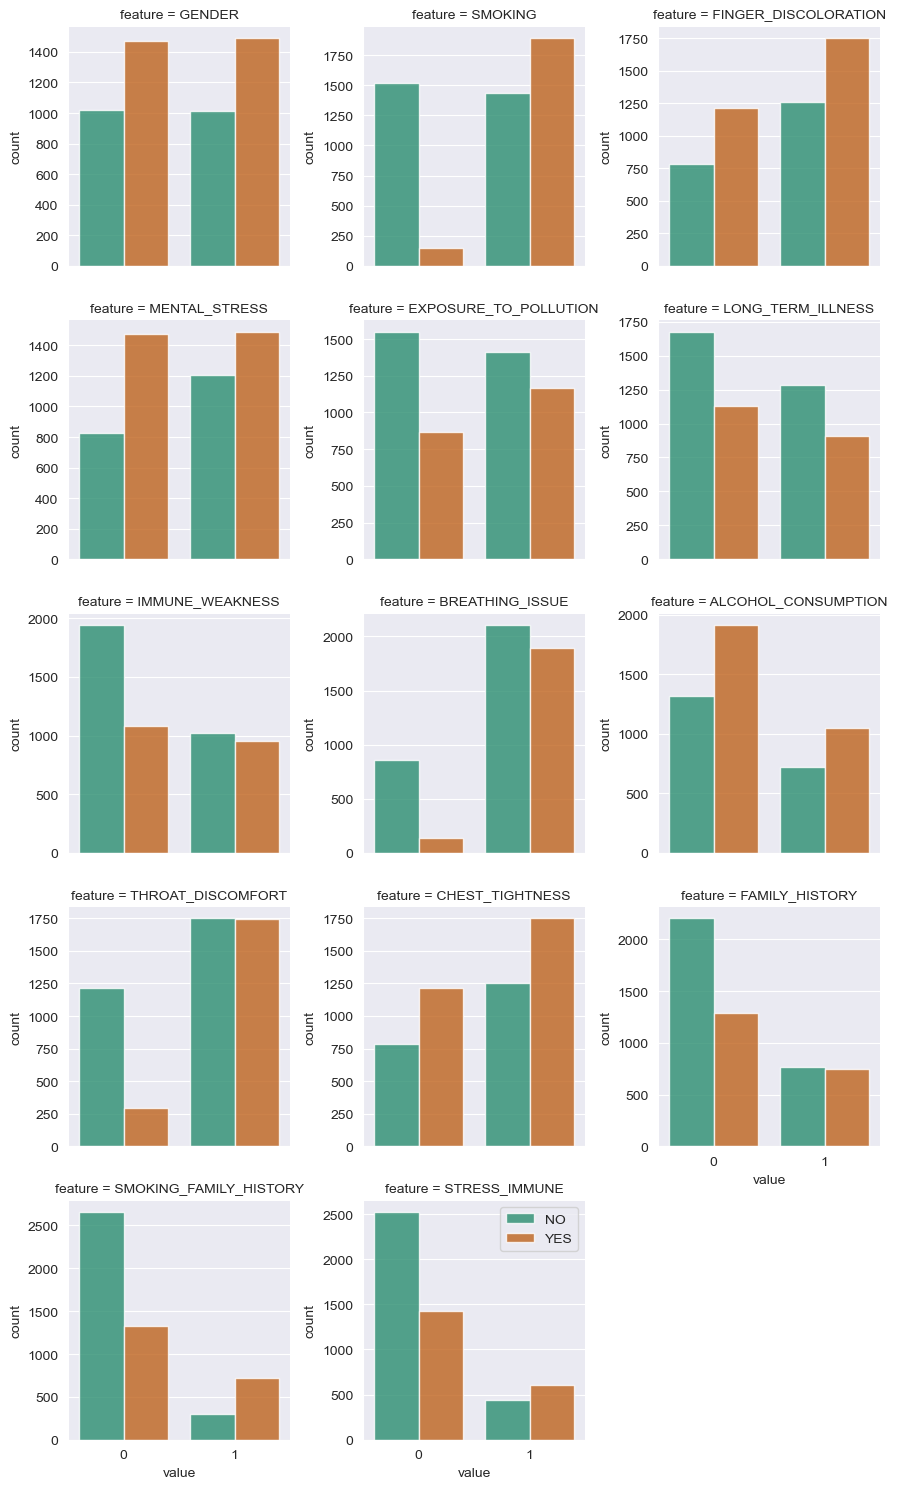

In [130]:
plot_count_facets(df, "PULMONARY_DISEASE")

# Fit random forest and check feature importances

In [7]:
#preprocessing pipelines
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(sparse_output=False,
                                                                   handle_unknown="ignore").set_output(transform="pandas"))
                                          ])
numeric_transformer_tree = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas"))
                                      ])
preprocessor_tree = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer_tree, features_num),
                                               ("cat", categorical_transformer, features_cat)
                                               ]).set_output(transform="pandas")
preprocessor_tree

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer',
                                                  KNNImputer())]),
                                 ['AGE', 'ENERGY_LEVEL', 'OXYGEN_SATURATION']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GENDER', 'SMOKING', 'FINGER_DISCOLORATION',
                                  'MENTAL_STRESS', 'EXPOSURE_TO_POLLUTION',
                                  'LONG_TERM_ILLNESS', 'IMMUNE_WEAKNESS',
                                  'BREATHING_ISSUE', 'ALCOHOL_CONSUMPTION',
                                  'THROAT_DISCOMFORT', 'CHEST_TIGHTNESS',
                                  'FAMILY_HISTORY', 'SMOKING_FAMILY_HISTORY',
                                  'STRESS_IMMUNE'])])

## Modeling pipeline

In [8]:
#initialize random forest classifier
rf = RandomForestClassifier(random_state=42)

pipeline_rf = Pipeline([("pre_process", preprocessor_tree),
                         ("model", rf)])
pipeline_rf

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer())]),
                                                  ['AGE', 'ENERGY_LEVEL',
                                                   'OXYGEN_SATURATION']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GENDER', 'SMOKING',
                                                   'FINGER_DISCOLORATION',
                                                   'MENTAL_STRESS',
                                                   'EXPOSURE_TO_POLLUTION',
                                                   'LONG_TERM_ILLNESS',
                                                   'IMMUNE_WEAKNESS',
                                                   'BREATHING_ISSUE',
                                                   'ALCOHOL_CONSUMPTION',
                                                   'THROAT_DISCOMFORT',
                                                   'CHEST_TIGHTNESS',
                                                   'FAMILY_HISTORY',
                                                   'SMOKING_FAMILY_HISTORY',
                                                   'STRESS_IMMUNE'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [9]:
# baseline random forest
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)

class_labels = pipeline_rf.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          NO       0.92      0.93      0.92       907
         YES       0.89      0.87      0.88       593

    accuracy                           0.91      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.91      0.91      0.91      1500



,NO,YES
NO,842,65
YES,75,518


## Plot RandomForest feature importances

In [10]:
rf_model = pipeline_rf['model']
feature_names = pipeline_rf['pre_process'].get_feature_names_out()

rf_importances = pd.DataFrame(
    {"feature": feature_names, "importance": np.round(rf_model.feature_importances_, 3)}
)
rf_importances = rf_importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
print(rf_importances["importance"].count())
#look at first 20 most important features
top_20= rf_importances.head(20)

31


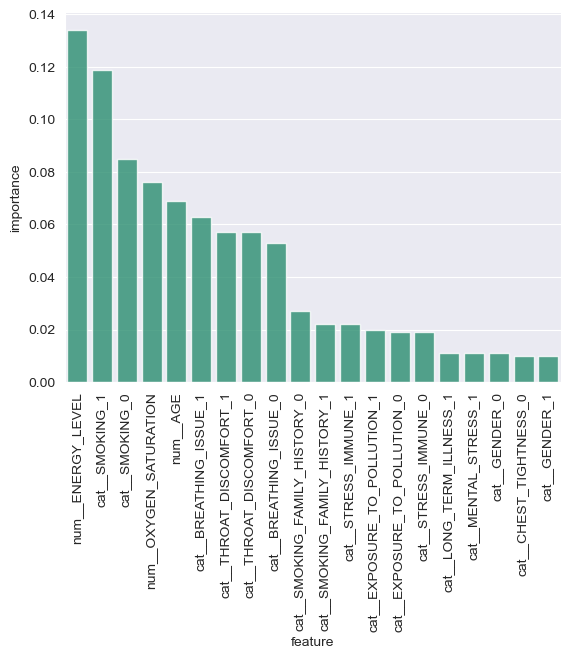

In [11]:
sns.barplot(data= top_20, x= "feature", y= "importance",
           color= "#1b9e77", alpha= 0.8)
plt.xticks(rotation= 90);

## Feature engineering

In [131]:
df["is_smoking_and_breathing_issue"] = df["SMOKING"] & df["BREATHING_ISSUE"]
df["is_smoking_and_throat_discomfort"]= df["SMOKING"] & df["THROAT_DISCOMFORT"]
df["is_smoking_and_smoke_fam_hist"]= df["SMOKING"] & df["SMOKING_FAMILY_HISTORY"]
#df["age_group"] = pd.cut(df["AGE"], bins=[0, 30, 50, 100], labels=["Under30", "30-50", "50+"])
df["smoking_by_age"]= df["SMOKING"] * df["AGE"]
df["energy_level_smoker"]= df["SMOKING"] * df["ENERGY_LEVEL"]
#df["energy_o2_sat"]= df["ENERGY_LEVEL"]* df["OXYGEN_SATURATION"]
mean_energy= df["ENERGY_LEVEL"].mean()
mean_02sat= df["OXYGEN_SATURATION"].mean()
df["energy_diff"]= df["ENERGY_LEVEL"] - mean_energy
df["o2sat_diff"]= df["OXYGEN_SATURATION"] - mean_02sat
df.columns

Index(['AGE', 'GENDER', 'SMOKING', 'FINGER_DISCOLORATION', 'MENTAL_STRESS',
       'EXPOSURE_TO_POLLUTION', 'LONG_TERM_ILLNESS', 'ENERGY_LEVEL',
       'IMMUNE_WEAKNESS', 'BREATHING_ISSUE', 'ALCOHOL_CONSUMPTION',
       'THROAT_DISCOMFORT', 'OXYGEN_SATURATION', 'CHEST_TIGHTNESS',
       'FAMILY_HISTORY', 'SMOKING_FAMILY_HISTORY', 'STRESS_IMMUNE',
       'PULMONARY_DISEASE', 'is_smoking_and_breathing_issue',
       'is_smoking_and_throat_discomfort', 'is_smoking_and_smoke_fam_hist',
       'smoking_by_age', 'energy_level_smoker', 'energy_diff', 'o2sat_diff'],
      dtype='object')

In [132]:
features= df.drop("PULMONARY_DISEASE", axis="columns")
target=df["PULMONARY_DISEASE"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=False)
X_train.shape, X_test.shape

((3500, 24), (1500, 24))

In [133]:
numeric= ["AGE", "ENERGY_LEVEL", "OXYGEN_SATURATION", "smoking_by_age", "energy_level_smoker",
         "energy_diff", "o2sat_diff"]
cat= ["GENDER", "SMOKING", "FINGER_DISCOLORATION", "MENTAL_STRESS", "EXPOSURE_TO_POLLUTION", "LONG_TERM_ILLNESS",
     "IMMUNE_WEAKNESS", "BREATHING_ISSUE", "ALCOHOL_CONSUMPTION", "THROAT_DISCOMFORT", "CHEST_TIGHTNESS",
     "FAMILY_HISTORY", "SMOKING_FAMILY_HISTORY", "STRESS_IMMUNE", "is_smoking_and_breathing_issue",
      "is_smoking_and_throat_discomfort", "is_smoking_and_smoke_fam_hist"]

features_num= X_train.drop(columns= cat).columns.tolist()
features_cat= X_train.drop(columns= numeric).columns.tolist()
df_num= df.drop(columns= cat)
df_cat= df.drop(columns= numeric)

In [134]:
#preprocessing pipelines
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(sparse_output=False,
                                                                   handle_unknown="ignore").set_output(transform="pandas"))
                                          ])
numeric_transformer_tree = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas"))
                                      ])
preprocessor_tree = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer_tree, features_num),
                                               ("cat", categorical_transformer, features_cat)
                                               ]).set_output(transform="pandas")
preprocessor_tree

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer',
                                                  KNNImputer())]),
                                 ['AGE', 'ENERGY_LEVEL', 'OXYGEN_SATURATION',
                                  'smoking_by_age', 'energy_level_smoker',
                                  'energy_diff', 'o2sat_diff']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GENDER', 'SMOKING', 'FINGER_DISCOLORATION',
                                  'MENTAL_STRESS', 'EXPOSURE_TO_POLLUTION',
                                  'LONG_TERM_ILLNESS', 'IMMUNE_WEAKNESS',
                                  'BREATHING_ISSUE', 'ALCOHOL_CONSUMPTION',
                                  'THROAT_DISCOMFORT', 'CHEST_TIGHTNESS',
                                  'FAMILY_HISTORY', 'SMOKING_FAMILY_HISTORY',
                                  'STRESS_IMMUNE',
                                  'is_smoking_and_breathing_issue',
                                  'is_smoking_and_throat_discomfort',
                                  'is_smoking_and_smoke_fam_hist'])])

In [135]:
#initialize random forest classifier
rf = RandomForestClassifier(random_state=42)

pipeline_rf = Pipeline([("pre_process", preprocessor_tree),
                         ("model", rf)])
pipeline_rf

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer())]),
                                                  ['AGE', 'ENERGY_LEVEL',
                                                   'OXYGEN_SATURATION',
                                                   'smoking_by_age',
                                                   'energy_level_smoker',
                                                   'energy_diff',
                                                   'o2sat_diff']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GENDER', 'SMOKING',
                                                   'FINGER_...
                                                   'EXPOSURE_TO_POLLUTION',
                                                   'LONG_TERM_ILLNESS',
                                                   'IMMUNE_WEAKNESS',
                                                   'BREATHING_ISSUE',
                                                   'ALCOHOL_CONSUMPTION',
                                                   'THROAT_DISCOMFORT',
                                                   'CHEST_TIGHTNESS',
                                                   'FAMILY_HISTORY',
                                                   'SMOKING_FAMILY_HISTORY',
                                                   'STRESS_IMMUNE',
                                                   'is_smoking_and_breathing_issue',
                                                   'is_smoking_and_throat_discomfort',
                                                   'is_smoking_and_smoke_fam_hist'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [136]:
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)

class_labels = pipeline_rf.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          NO       0.92      0.93      0.92       907
         YES       0.89      0.87      0.88       593

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



,NO,YES
NO,840,67
YES,77,516


In [137]:
rf_model = pipeline_rf['model']
feature_names = pipeline_rf['pre_process'].get_feature_names_out()

rf_importances = pd.DataFrame(
    {"feature": feature_names, "importance": np.round(rf_model.feature_importances_, 3)}
)
rf_importances = rf_importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
print(rf_importances["importance"].count())
#look at first 20 most important features
top_20= rf_importances.head(20)

41


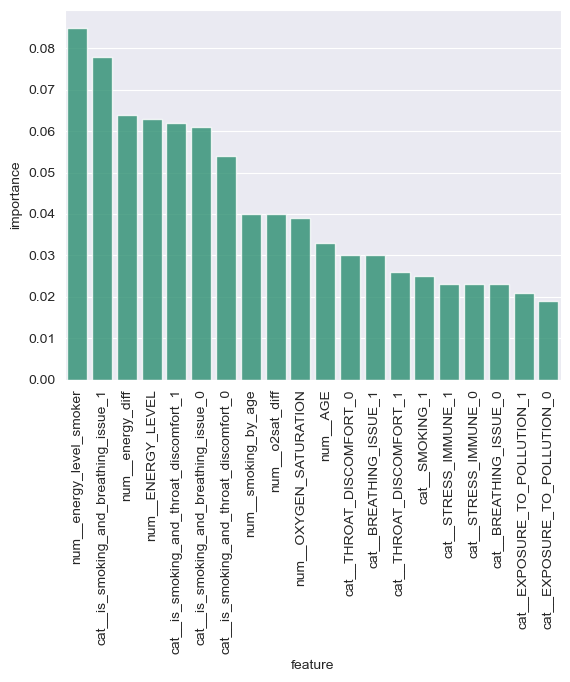

In [138]:
sns.barplot(data= top_20, x= "feature", y= "importance",
           color= "#1b9e77", alpha= 0.8)
plt.xticks(rotation= 90);

## Catboost

In [139]:
#initialize catboost classifier
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42)

pipeline_cat = Pipeline([("pre_process", preprocessor_tree),
                         ("model", cat)])
pipeline_cat

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer())]),
                                                  ['AGE', 'ENERGY_LEVEL',
                                                   'OXYGEN_SATURATION',
                                                   'smoking_by_age',
                                                   'energy_level_smoker',
                                                   'energy_diff',
                                                   'o2sat_diff']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GENDER', 'SMOKING',
                                                   'FINGER_...
                                                   'EXPOSURE_TO_POLLUTION',
                                                   'LONG_TERM_ILLNESS',
                                                   'IMMUNE_WEAKNESS',
                                                   'BREATHING_ISSUE',
                                                   'ALCOHOL_CONSUMPTION',
                                                   'THROAT_DISCOMFORT',
                                                   'CHEST_TIGHTNESS',
                                                   'FAMILY_HISTORY',
                                                   'SMOKING_FAMILY_HISTORY',
                                                   'STRESS_IMMUNE',
                                                   'is_smoking_and_breathing_issue',
                                                   'is_smoking_and_throat_discomfort',
                                                   'is_smoking_and_smoke_fam_hist'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x140f577c0>)])

In [140]:

pipeline_cat.fit(X_train, y_train)

y_pred = pipeline_cat.predict(X_test)

class_labels = pipeline_cat.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          NO       0.92      0.92      0.92       907
         YES       0.88      0.88      0.88       593

    accuracy                           0.91      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.91      0.91      0.91      1500



,NO,YES
NO,836,71
YES,71,522


### Catboost tuning

In [141]:
X_train_transformed = preprocessor_tree.fit_transform(X_train)
X_test_transformed= preprocessor_tree.transform(X_test)

In [142]:
#general tuning catboost
from sklearn.model_selection import StratifiedKFold

param_distributions = {
    'iterations': [250, 275, 300, 325, 350],
    'learning_rate': [0.04, 0.045, 0.05, 0.055, 0.06],
    'depth': [7, 8, 9],
    'l2_leaf_reg': [0.5, 0.75, 1, 1.25, 1.5]
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator= CatBoostClassifier(verbose= 0),
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter settings sampled
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Fit the randomized search
random_search.fit(X_train_transformed, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': 0.04, 'l2_leaf_reg': 1.25, 'iterations': 250, 'depth': 7}
Best score: 0.9125126100293477


In [144]:
c_boost= CatBoostClassifier(iterations=250, random_state=42, verbose=0,
                           depth=7, learning_rate= 0.04, l2_leaf_reg= 1.25)

## train model
c_boost.fit(X_train_transformed, y_train)
y_pred= c_boost.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          NO       0.92      0.93      0.92       907
         YES       0.89      0.88      0.88       593

    accuracy                           0.91      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.91      0.91      0.91      1500



,NO,YES
NO,840,67
YES,73,520


False negatives increased

## Tune rf model

In [66]:
# rf tuning
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 20],
    'max_features': ['sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=80,  # Adjust the number of iterations as needed
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train_transformed, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.3, 'max_depth': 10}
Best score: 0.9120000000000001


In [71]:
#focused tuning
param_distributions = {
    'n_estimators': [400, 450, 500, 550, 600],
    'max_depth': [None, 10, 12, 13, 14, 15],
    'min_samples_split': [10, 12, 14, 16],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,  # Adjust the number of iterations as needed
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train_transformed, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'n_estimators': 550, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': 13}
Best score: 0.9117142857142857


In [152]:
rf_best= RandomForestClassifier(n_estimators=550, random_state=42, min_samples_split=12,
                           min_samples_leaf=1, max_features= 0.3, max_depth= 13)

## train model
rf_best.fit(X_train_transformed, y_train)
rf_best= rf_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

          NO       0.92      0.93      0.92       907
         YES       0.89      0.88      0.88       593

    accuracy                           0.91      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.91      0.91      0.91      1500



,NO,YES
NO,840,67
YES,73,520


Same as tuned Catboost

Catboost classifier before model tuning had the best performance scores (91%) and had the lowest number of false negative classification (predicted no pulmonary disease when the patient, in fact, had pulmonary disease)